# Data Preprocessing

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Load dataset
data_train = pd.read_csv('/Data/Visual Studio Code/Data Science/Dataset/UNSW-NB15/UNSW_NB15_training-set.csv')
data_test = pd.read_csv('/Data/Visual Studio Code/Data Science/Dataset/UNSW-NB15/UNSW_NB15_testing-set.csv')

In [6]:
# Handle missing value and duplicate if any
data_train.dropna(inplace=True)
data_train.drop_duplicates(inplace=True)

data_test.dropna(inplace=True)
data_test.drop_duplicates(inplace=True)

In [7]:
#Split Attack and Normal from dataframe
data_train_attack = data_train[data_train['label'] == 1]
data_test_attack = data_test[data_test['label'] == 1]

#Optional
#data_train_normal = data_train[data_train['label'] == 0]
#data_test_normal = data_test[data_test['label'] == 0]

In [8]:
# Drop id and label from train and test data
data_train_attack = data_train_attack.drop('id', axis=1)
data_train_attack = data_train_attack.drop('label', axis=1)

data_test_attack = data_test_attack.drop('id', axis=1)
data_test_attack = data_test_attack.drop('label', axis=1)

In [9]:
print(data_train_attack['state'].nunique())
print(data_test_attack['state'].nunique())

6
5


In [10]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'ACC' 'CON' 'REQ' 'CLO']
['INT' 'FIN' 'CON' 'REQ' 'RST']


In [11]:
#Drop ACC, CLO, and RST from data
data_train_attack = data_train_attack[(data_train_attack['state'] != 'ACC') & (data_train_attack['state'] != 'CLO')]
data_test_attack = data_test_attack[(data_test_attack['state'] != 'RST')]

In [12]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'CON' 'REQ']
['INT' 'FIN' 'CON' 'REQ']


## Encode Train and Test Data

In [13]:
#column to encode
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [14]:
#One-hot Encoding
# Encode train data
data_train_attack = pd.get_dummies(data_train_attack, columns=cols)

# Encode test data
data_test_attack = pd.get_dummies(data_test_attack, columns=cols)

In [15]:
train_attack_cat = data_train_attack.pop('attack_cat')
test_attack_cat = data_test_attack.pop('attack_cat')

## Normalization

In [16]:
# Min-Max Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols_to_norm = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 
                'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 
                'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 
                'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 
                'ct_srv_dst', 'is_sm_ips_ports']

data_train_attack[cols_to_norm] = scaler.fit_transform(data_train_attack[cols_to_norm])
data_test_attack[cols_to_norm] = scaler.fit_transform(data_test_attack[cols_to_norm])

## Feature Selection

In [17]:
#Feature Selection
feature = data_train_attack.drop(['dinpkt', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'is_sm_ips_ports'], axis=1)
feature.dtypes

dur               float64
spkts             float64
dpkts             float64
sbytes            float64
dbytes            float64
                   ...   
service_radius       bool
service_smtp         bool
service_snmp         bool
service_ssh          bool
service_ssl          bool
Length: 181, dtype: object

# Balancing Data

In [18]:
#Splitting the dataset into dependent and independent feature
X_train = feature
y_train = train_attack_cat

X_test = data_test_attack.drop(columns=['dinpkt', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'is_sm_ips_ports'])
y_test = test_attack_cat

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((45329, 181), (45329,), (119329, 181), (119329,))

## ADASYN

In [21]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

X_adasyn.shape, y_adasyn.shape

((168484, 181), (168484,))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Reconnaissance'),
  Text(1, 0, 'Backdoor'),
  Text(2, 0, 'DoS'),
  Text(3, 0, 'Exploits'),
  Text(4, 0, 'Analysis'),
  Text(5, 0, 'Fuzzers'),
  Text(6, 0, 'Worms'),
  Text(7, 0, 'Shellcode'),
  Text(8, 0, 'Generic')])

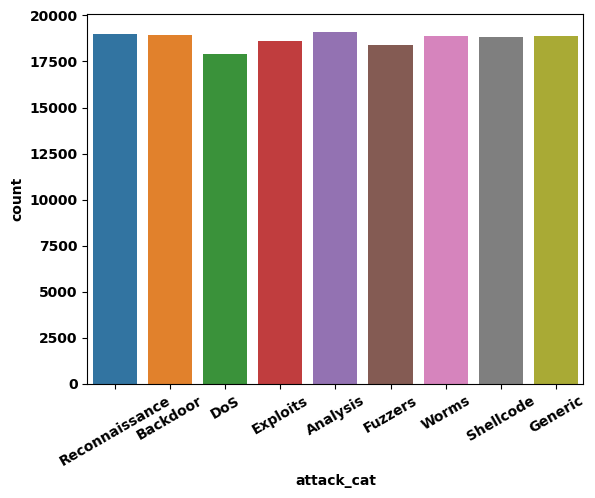

In [22]:
#Create new dataframe from X_adasyn and y_adasyn to count every attack
data_adasyn = pd.concat([X_adasyn, y_adasyn], axis=1)

sns.countplot(data=data_adasyn, x="attack_cat")
plt.xticks(rotation=30)

In [23]:
#data_adasyn.drop_duplicates(inplace=True)
print(data_adasyn.value_counts('attack_cat'))
print("--------------------")
print("Shape: " + str(data_adasyn.shape))
print("--------------------")
print("Duplicates: " + str(data_adasyn.duplicated().sum()))

attack_cat
Analysis          19111
Reconnaissance    19010
Backdoor          18926
Generic           18871
Worms             18856
Shellcode         18828
Exploits          18606
Fuzzers           18379
DoS               17897
Name: count, dtype: int64
--------------------
Shape: (168484, 182)
--------------------
Duplicates: 44943


# Model Architecture

In [19]:
# import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.metrics import Recall, Precision

## CNN Model

In [20]:
# Define the input shape
input_shape = (181, 1)

#Create the sequential model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2)) # reduces the spatial dimensions of the output volume
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D()) # computes the average of all values across the spatial dimensions, effectively flattening the data
model.add(Dropout(0.5)) # helps prevent overfitting by randomly setting a fraction of input units to 0 during training
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])

In [21]:
#Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 179, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 89, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 87, 128)           24704     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               3

## Train the model

In [24]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [25]:
le = LabelEncoder()

y_adasyn = le.fit_transform(y_adasyn)
y_test = le.fit_transform(y_test)

In [26]:
num_class = 9
y_adasyn = to_categorical(y_adasyn, num_class)
y_test = to_categorical(y_test, num_class)

In [27]:
X_adasyn = np.array(X_adasyn, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

In [26]:
#Define epochs and batch size
epochs = 50
batch_size = 32

#Train the model
history = model.fit(X_adasyn, y_adasyn, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
5266/5266 [==============================] - 59s 11ms/step - loss: 1.5867 - accuracy: 0.3898 - recall: 0.1566 - precision: 0.8024 - val_loss: 1.2406 - val_accuracy: 0.4603 - val_recall: 0.4270 - val_precision: 0.8788
Epoch 2/50
5266/5266 [==============================] - 55s 10ms/step - loss: 1.3865 - accuracy: 0.4536 - recall: 0.2082 - precision: 0.7853 - val_loss: 1.1619 - val_accuracy: 0.5397 - val_recall: 0.4423 - val_precision: 0.8203
Epoch 3/50
5266/5266 [==============================] - 55s 10ms/step - loss: 1.2293 - accuracy: 0.5145 - recall: 0.2710 - precision: 0.7793 - val_loss: 1.0462 - val_accuracy: 0.5914 - val_recall: 0.4844 - val_precision: 0.8631
Epoch 4/50
5266/5266 [==============================] - 55s 10ms/step - loss: 1.1477 - accuracy: 0.5438 - recall: 0.3240 - precision: 0.7760 - val_loss: 1.0419 - val_accuracy: 0.6024 - val_recall: 0.4711 - val_precision: 0.8355
Epoch 5/50
5266/5266 [==============================] - 55s 11ms/step - loss: 1.1044 - a

# Evaluate The Model

In [28]:
#Evaluate the model on test data
loss, accuracy, recall, precision = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Test Recall:', recall)
print('Test Precision:', precision)

3730/3730 [==============================] - 14s 4ms/step - loss: 0.9469 - accuracy: 0.6546 - recall: 0.5891 - precision: 0.7968
Test Loss: 0.9469043016433716
Test Accuracy: 0.6545852422714233
Test Recall: 0.5891023874282837
Test Precision: 0.7968374490737915


In [29]:
# make a predictions
predictions = model.predict(X_test)

3730/3730 [==============================] - 12s 3ms/step


In [30]:
# convert one-hot encode predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
y_test_categorical = np.argmax(y_test, axis=1)

### Confusion Matrix

In [31]:
# function to calculate recall from confusion matrix
def calculate_recall(confusion_matrix):
    num_class = len(confusion_matrix)
    recalls = []

    for i in range(num_class):
        true_positive = confusion_matrix[i][i]
        false_negative = sum(confusion_matrix[i]) - true_positive

        recall = true_positive / (true_positive + false_negative)
        recalls.append(recall)
    
    return recalls

In [32]:
# function to display the recall score
def display_recall(recalls):
    print('Recall Scores for each class:')
    print('Analysis:', recalls[0])
    print('Backdoor:', recalls[1])
    print('DoS:', recalls[2])
    print('Exploits:', recalls[3])
    print('Fuzzers:', recalls[4])
    print('Generic:', recalls[5])
    print('Reconnaissance:', recalls[6])
    print('Shellcode:', recalls[7])
    print('Worms:', recalls[8])

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
matrix = confusion_matrix(y_test_categorical, predicted_classes)
matrix_df = pd.DataFrame(matrix, 
                         index= ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'], 
                         columns= ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'])

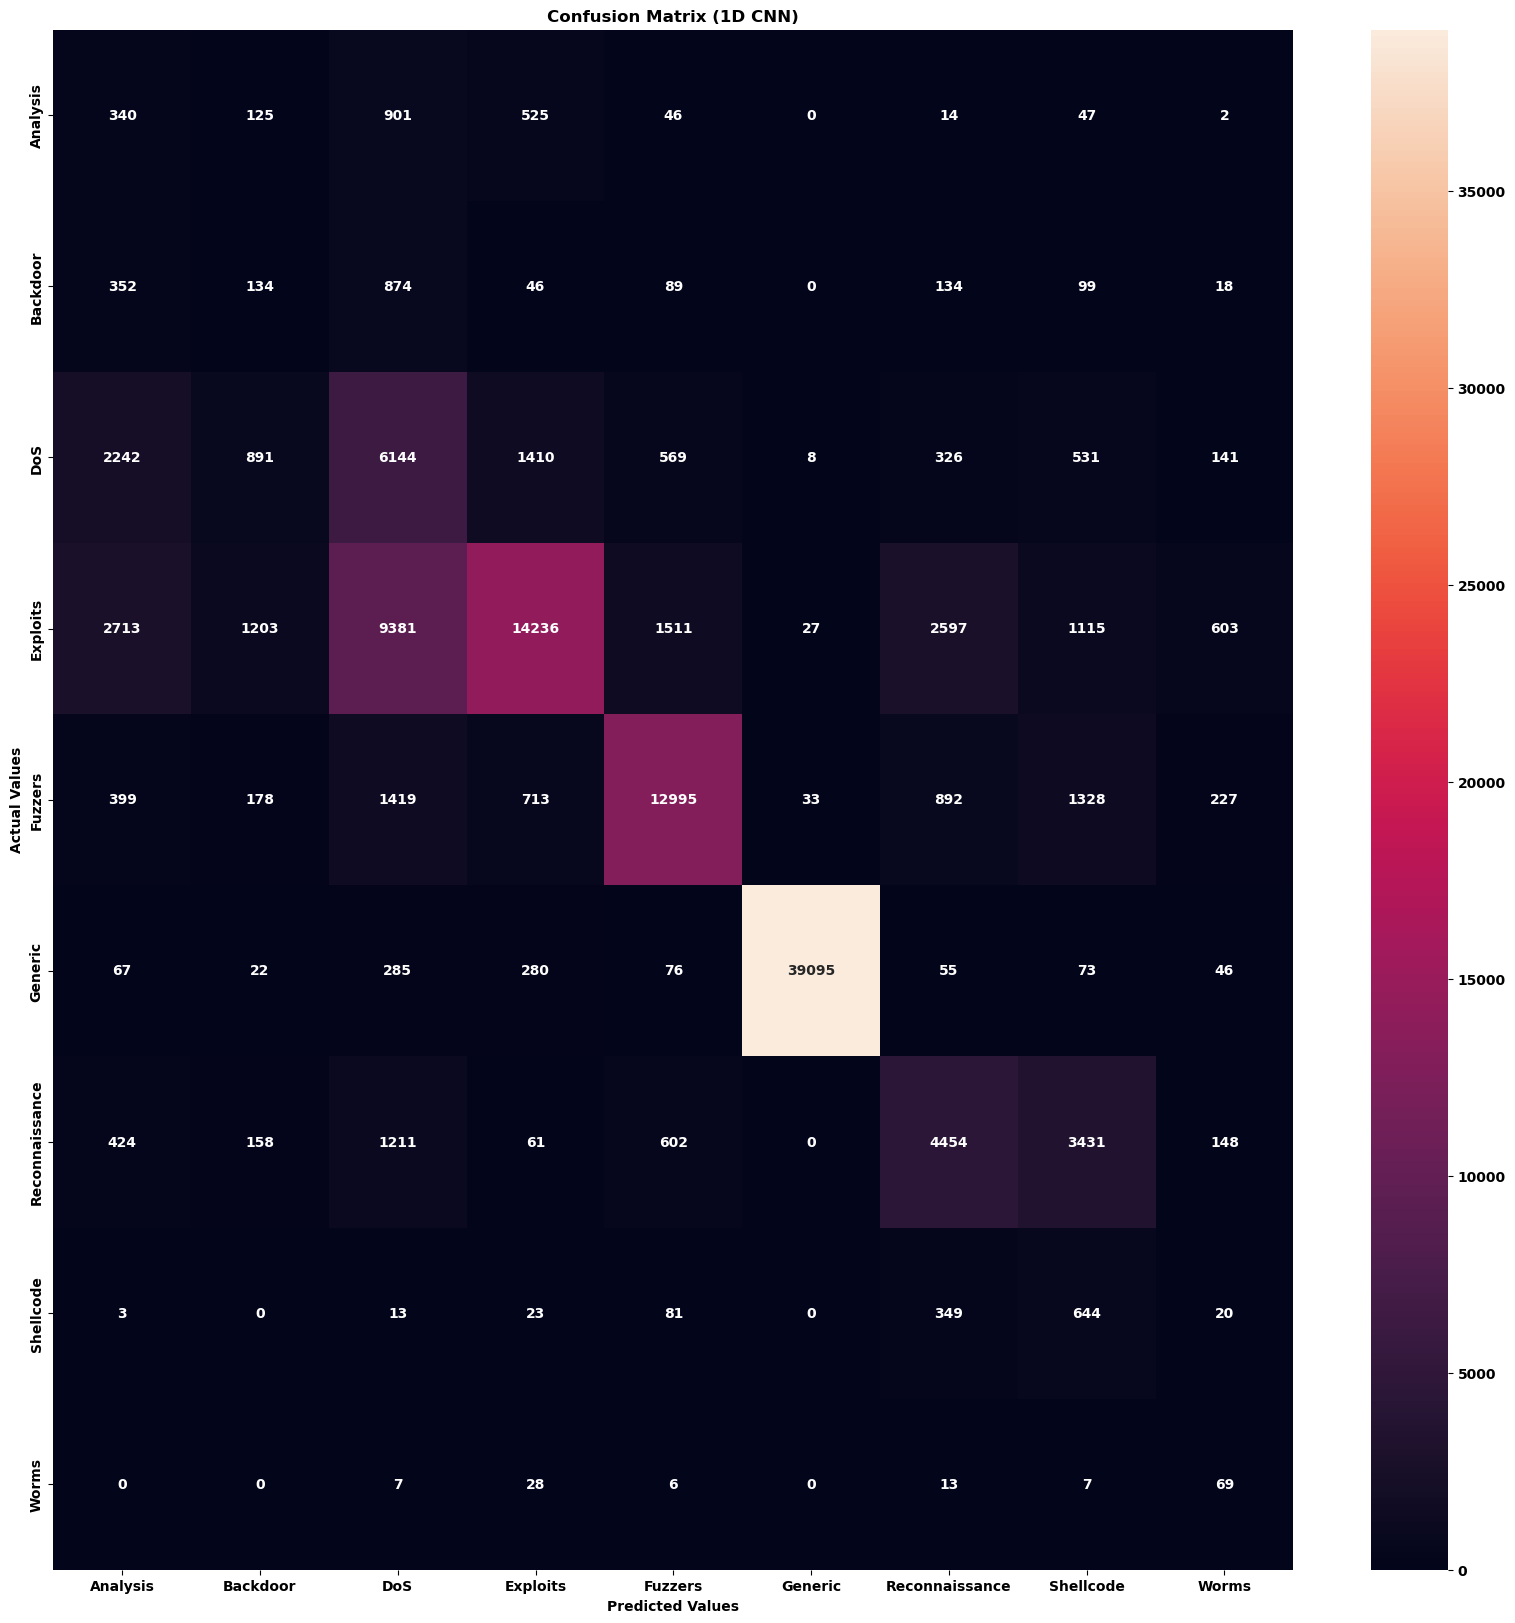

In [35]:
# Plotting Confusion Matrix
plt.figure(figsize = (20, 20))
sns.heatmap(matrix_df, fmt='.0f', annot=True)
plt.title('Confusion Matrix (1D CNN)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [36]:
recalls = calculate_recall(matrix)
display_recall(recalls)

Recall Scores for each class:
Analysis: 0.17
Backdoor: 0.07674684994272624
DoS: 0.5010601859403033
Exploits: 0.4264062780806326
Fuzzers: 0.7146392432908051
Generic: 0.9773994349858747
Reconnaissance: 0.4246353322528363
Shellcode: 0.5684024713150927
Worms: 0.5307692307692308


## Save and load the model

In [1]:
from keras.models import load_model

In [ ]:
# save the 1D CNN trained model using keras
model.save('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Balanced/ADASYN/Saved/cnn1d.keras')

In [3]:
# load the 1D CNN trained model using keras
model = load_model('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Balanced/ADASYN/Saved/cnn1d.keras')

## Save and load the predicted

In [ ]:
import pickle

In [39]:
# save the decision tree trained model
with open('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Balanced/ADASYN/Saved/predicted_classes.pkl', 'wb') as model_file:
    pickle.dump(predicted_classes, model_file)

In [40]:
# load the decision tree trained model
with open('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Balanced/ADASYN/Saved/predicted_classes.pkl', 'rb') as model_file:
    predicted_classes = pickle.load(model_file)